In [1]:
import sys
sys.path.append('../src')

In [2]:
import numpy as np
import pcalg
import networkx as nx
from conditional_independence import partial_correlation_suffstat, partial_correlation_test
from structure_learning.samplers import PartitionMCMC
from structure_learning.data import SyntheticDataset
from structure_learning.proposals import PartitionProposal
from structure_learning.scores import BGeScore

In [3]:
np.random.seed(21082024)

num_nodes = 5
node_labels = [chr(ord('a') + i) for i in range(num_nodes)]
num_obs = 200
degree = 2
synthetic_data = SyntheticDataset(num_nodes=num_nodes, num_obs=num_obs, node_labels=node_labels, degree=degree)

00000 10000 00000 00100 00000


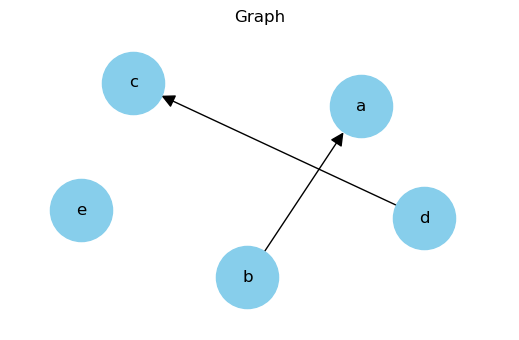

In [4]:
# visualise ground truth DAG
synthetic_data.graph.plot()

In [5]:
synthetic_data.data

In [6]:
# setup mcmc
M = PartitionMCMC(max_iter=30000, data=synthetic_data.data, score_object='bge', pc_init=False, result_type='distribution')

{0, 3}
{0, 2, 3, 4}
{0, 1, 2, 3, 4}
None
Precomputed score tables


In [7]:
# run experiment
mcmc_results, acceptance = M.run()
print('Acceptance_ratio:', acceptance)

Acceptance_ratio: 0.1573


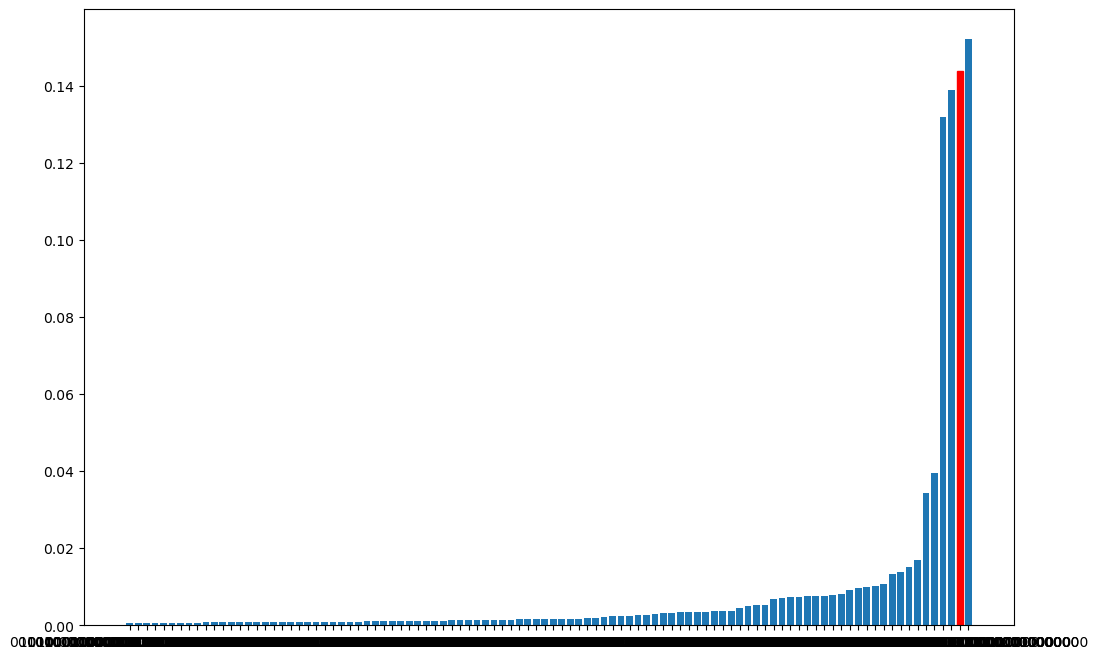

In [8]:
from matplotlib import pyplot as plt

key = synthetic_data.graph.to_key()
plt.rcParams['figure.figsize'] = 12,8
bars, keys, counts = mcmc_results.plot(sort=True, normalise=True, limit=100)
bars[np.where(np.array(keys)==key)[0][0]].set_color('red')

In [9]:
from structure_learning.distributions import Distribution
from structure_learning.scores import BGeScore, BDeuScore

true_dist = Distribution.compute_distribution(synthetic_data.data, score=BGeScore)

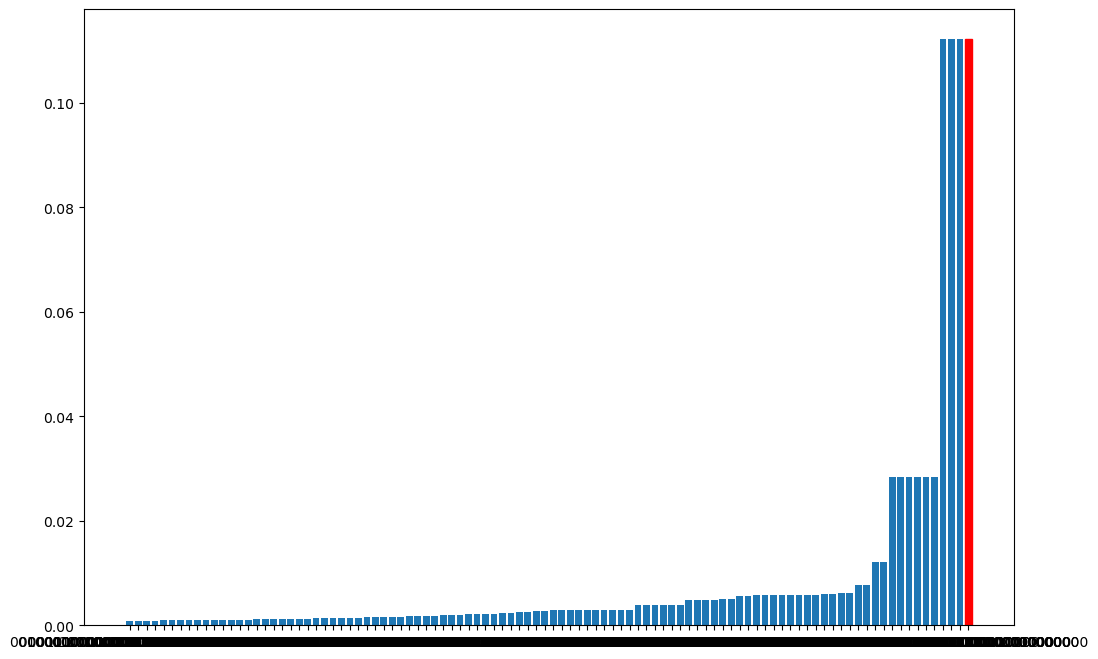

In [10]:
bars2, keys, counts = true_dist.plot(prop='p', sort=True, limit=100)
bars2[np.where(np.array(keys)==key)[0][0]].set_color('red')

In [11]:
from mcmc.evaluation.metrics import kl_divergence, jensen_shannon_divergence, mean_squared_error, mean_absolute_error
from mcmc.inference.posterior import generate_all_dags_keys, generate_all_dags

all_dags = generate_all_dags(data=synthetic_data.data, my_score=BGeScore)


ModuleNotFoundError: No module named 'mcmc'

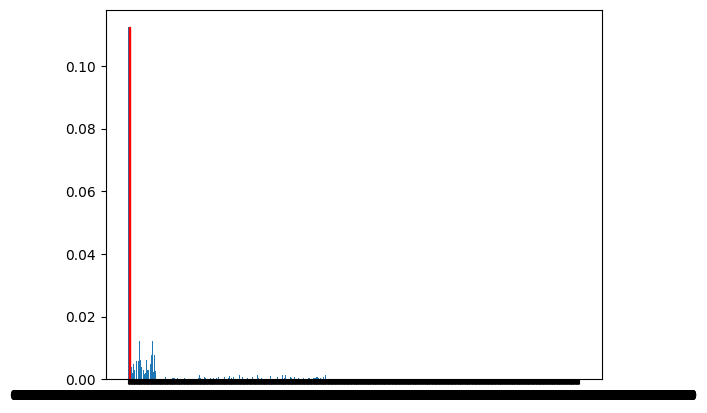

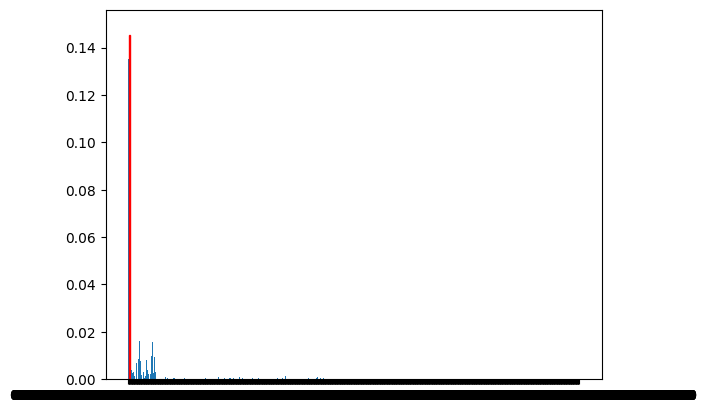

In [ ]:

from mcmc.inference.posterior import compute_true_distribution

true_distribution = compute_true_distribution(all_dags)
dst = {key:count/sum(counts) for key, count in zip(keys, counts)}
approx_distribution = {key: (dst[key] if key in dst else 0) for key in true_distribution.keys()}

threshold = 1e-5
k = list(true_distribution.keys())
for _k in k:
    if true_distribution[_k] < threshold and approx_distribution[_k] < threshold:
        del true_distribution[_k]
        del approx_distribution[_k]
k = np.array(list(true_distribution.keys()))
bars = plt.bar(k, true_distribution.values())
# print(k, key)
bars[np.where(k==key)[0][0]].set_color('red')
plt.figure()
bars = plt.bar(approx_distribution.keys(), approx_distribution.values())
bars[np.where(k==key)[0][0]].set_color('red')

In [ ]:
from mcmc.evaluation.metrics import mean_squared_error, mean_absolute_error, kl_divergence, jensen_shannon_divergence

print('KL div', kl_divergence(true_distribution, approx_distribution))
print('JS div', jensen_shannon_divergence(true_distribution, approx_distribution))
print('MSE', mean_squared_error(true_distribution, approx_distribution))
print('MAE', mean_absolute_error(true_distribution, approx_distribution))

KL div 0.5880734077401519
JS div 0.02634737997568662
MSE 4.30093649258381e-06
MAE 0.00030400561574337034
